In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re


In [ ]:
DATA_FILE = Path(r"E:\CUNY\Fall 25\CSC 47400 Visualization\HW\HW1\Appendix B (shares).xls")

PERIODS = ["1994-1998", "2003-2004", "2005-2006", "2007-2008"]

FRUITS = [
    "Apples as fruit","Bananas","Berries","Grapes","Melons",
    "Oranges, Total","Other citrus fruit","Stone fruit","Tropical fruit",
]
DAIRY = ["Fluid milk total","Butter","Cheese","Yogurt","Dairy, Other"]

# In most copies, product names are in the first column. If you discover they sit in col 1 or 2, change this to 1 or 2.
PRODUCT_NAME_COL = 0

SOURCE_TEXT = ("Source: USDA ERS, 'U.S. Food Commodity Availability by Food Source (LAFA), 1994–2008' – "
               "Appendix B (Food At Home). Means in pounds per person. "
               "URL: https://www.ers.usda.gov/publications/pub-details/?pubid=81817")


In [ ]:
#assert DATA_FILE.exists(), f"File not found: {DATA_FILE.resolve()}"

xls = pd.ExcelFile(DATA_FILE)
all_sheets = xls.sheet_names
print("Sheets:\n", all_sheets)


Sheets:
 ['94-98 FAH', '94-98 FAFH', '03-04 FAH', '03-04 FAFH', '05-06 FAH', '05-06 FAFH', '07-08 FAH', '07-08 FAFH']


In [ ]:
#assert DATA_FILE.exists(), f"File not found: {DATA_FILE.resolve()}"

xls = pd.ExcelFile(DATA_FILE)
all_sheets = xls.sheet_names
print("Sheets:\n", all_sheets)


Sheets:
 ['94-98 FAH', '94-98 FAFH', '03-04 FAH', '03-04 FAFH', '05-06 FAH', '05-06 FAFH', '07-08 FAH', '07-08 FAFH']


In [ ]:
#assert DATA_FILE.exists(), f"File not found: {DATA_FILE.resolve()}"

xls = pd.ExcelFile(DATA_FILE)
all_sheets = xls.sheet_names
print("Sheets:\n", all_sheets)


Sheets:
 ['94-98 FAH', '94-98 FAFH', '03-04 FAH', '03-04 FAFH', '05-06 FAH', '05-06 FAFH', '07-08 FAH', '07-08 FAFH']


In [ ]:
test_string = "1994 - 1998 FAH"
print(_norm(test_string))

19941998fah


In [ ]:
# This is small and essential; it avoids picking the wrong 'Mean' column.
def find_block_and_mean(df: pd.DataFrame, sex_label: str):
    HEADER_SCAN_ROWS = 80
    LOOKAHEAD_FOR_MEAN = 8

    sex_n = _norm(sex_label)
    anchor = None

    # 1) find the cell that equals 'Men' or 'Women'
    for r in range(min(HEADER_SCAN_ROWS, df.shape[0])):
        for c in range(min(df.shape[1], 20)):
            v = df.iat[r, c]
            if isinstance(v, str) and _norm(v) == sex_n:
                anchor = (r, c)
                break
        if anchor: break
    if not anchor:
        for r in range(df.shape[0]):
            for c in range(min(df.shape[1], 20)):
                v = df.iat[r, c]
                if isinstance(v, str) and _norm(v) == sex_n:
                    anchor = (r, c)
                    break
            if anchor: break
    if not anchor:
        raise ValueError(f"Could not find header for {sex_label!r}")

    r0, c0 = anchor

    # 2) find 'Mean' below/near that sex column (often same col or +1/+2)
    mean_col = None
    mean_row = r0
    for rr in range(r0, min(r0 + LOOKAHEAD_FOR_MEAN, df.shape[0])):
        for cc in range(c0, min(c0 + 3, df.shape[1])):
            v = df.iat[rr, cc]
            if isinstance(v, str) and "mean" in v.lower():
                mean_col = cc
                mean_row = rr
                break
        if mean_col is not None:
            break
    if mean_col is None:
        # assignment fallback (7th column)
        mean_col = 6

    # 3) find the first plausible product row after the header block
    start_row = mean_row + 1
    stop_row = min(start_row + 50, df.shape[0])
    while start_row < stop_row:
        v = df.iat[start_row, PRODUCT_NAME_COL]
        if isinstance(v, str) and len(v.strip()) > 1:
            bad = _norm(v) in {"appendixtableb1lafaathomeshares1994","ustotal","age","mean","95ci"}
            if not bad:
                break
        start_row += 1

    return start_row, mean_col


In [ ]:
def lookup_item(df: pd.DataFrame, start_row: int, mean_col: int, item_name: str):
    MAX_SCAN_ROWS = 700
    t = _norm(item_name)
    end_row = min(df.shape[0], start_row + MAX_SCAN_ROWS)

    # exact (normalized)
    for r in range(start_row, end_row):
        v = df.iat[r, PRODUCT_NAME_COL]
        if isinstance(v, str) and _norm(v) == t:
            try:
                return float(df.iat[r, mean_col])
            except Exception:
                return None

    # contains (normalized)
    for r in range(start_row, end_row):
        v = df.iat[r, PRODUCT_NAME_COL]
        if isinstance(v, str) and t in _norm(v):
            try:
                return float(df.iat[r, mean_col])
            except Exception:
                return None

    return None


In [ ]:
rows = {}
for period in PERIODS:
    sheet = period_to_sheet[period]
    df = pd.read_excel(DATA_FILE, sheet_name=sheet, header=None)
    start_row, mean_col = find_block_and_mean(df, "Men")
    row = {}
    for item in FRUITS:
        row[item] = lookup_item(df, start_row, mean_col, item)
    rows[period] = row

df_men_fruit = pd.DataFrame.from_dict(rows, orient="index")[FRUITS].sort_index()
print("Men - Fruits")
print(df_men_fruit)


Men - Fruits
           Apples as fruit  Bananas  Berries  Grapes  Melons  Oranges, Total  \
1994-1998            89.18    95.42    84.21   88.79   80.74           85.66   
2003-2004            90.86    94.85    88.57   88.55   79.72           84.46   
2005-2006            89.70    95.59    91.83   93.65   80.85           86.00   
2007-2008            93.35    93.96    90.70   92.16   84.97           84.16   

           Other citrus fruit  Stone fruit  Tropical fruit  
1994-1998               79.82        88.95           74.61  
2003-2004               73.74        94.02           74.58  
2005-2006               72.95        93.05           76.94  
2007-2008               61.90        95.89           84.68  


In [ ]:
rows = {}
for period in PERIODS:
    sheet = period_to_sheet[period]
    df = pd.read_excel(DATA_FILE, sheet_name=sheet, header=None)
    start_row, mean_col = find_block_and_mean(df, "Women")
    row = {}
    for item in FRUITS:
        row[item] = lookup_item(df, start_row, mean_col, item)
    rows[period] = row

df_women_fruit = pd.DataFrame.from_dict(rows, orient="index")[FRUITS].sort_index()
print("Women - Fruits")
print(df_women_fruit)


Women - Fruits
           Apples as fruit  Bananas  Berries  Grapes  Melons  Oranges, Total  \
1994-1998            90.42    94.18    81.73   88.13   84.96           89.77   
2003-2004            91.21    94.57    88.29   90.14   80.99           88.07   
2005-2006            91.50    93.67    90.92   91.33   93.57           88.86   
2007-2008            91.69    94.20    87.99   90.02   85.48           89.35   

           Other citrus fruit  Stone fruit  Tropical fruit  
1994-1998               80.64        89.55           80.40  
2003-2004               69.60        87.94           85.85  
2005-2006               75.13        89.61           76.57  
2007-2008               77.85        94.30           80.72  


In [ ]:
rows = {}
for period in PERIODS:
    sheet = period_to_sheet[period]
    df = pd.read_excel(DATA_FILE, sheet_name=sheet, header=None)
    start_row, mean_col = find_block_and_mean(df, "Men")
    row = {}
    for item in DAIRY:
        row[item] = lookup_item(df, start_row, mean_col, item)
    rows[period] = row

df_men_dairy = pd.DataFrame.from_dict(rows, orient="index")[DAIRY].sort_index()
print("Men - Dairy")
print(df_men_dairy)


Men - Dairy
           Fluid milk total  Butter  Cheese  Yogurt  Dairy, Other
1994-1998             82.57   65.97   57.47   89.68         66.56
2003-2004             88.83   74.00   56.30   87.12         73.48
2005-2006             88.61   77.54   54.56   94.38         69.41
2007-2008             87.86   74.37   55.20   88.52         69.87


In [ ]:
rows = {}
for period in PERIODS:
    sheet = period_to_sheet[period]
    df = pd.read_excel(DATA_FILE, sheet_name=sheet, header=None)
    start_row, mean_col = find_block_and_mean(df, "Women")
    row = {}
    for item in DAIRY:
        row[item] = lookup_item(df, start_row, mean_col, item)
    rows[period] = row

df_women_dairy = pd.DataFrame.from_dict(rows, orient="index")[DAIRY].sort_index()
print("Women - Dairy")
print(df_women_dairy)


Women - Dairy
           Fluid milk total  Butter  Cheese  Yogurt  Dairy, Other
1994-1998             86.69   70.66   62.24   88.22         65.48
2003-2004             88.92   72.57   59.72   90.57         69.77
2005-2006             89.69   79.72   63.35   94.82         65.94
2007-2008             88.38   76.82   62.24   92.56         72.39


In [ ]:
def plot_lines(df: pd.DataFrame, title: str, ylabel="Mean pounds per person"):
    linestyles = ["-","--","-.",":",(0,(5,1)),(0,(3,1,1,1))]
    style_for = {col: linestyles[i % len(linestyles)] for i, col in enumerate(df.columns)}

    fig, ax = plt.subplots(figsize=(10,5))
    for col in df.columns:
        ax.plot(df.index, df[col], marker="o", linestyle=style_for[col], label=col)

    ax.set_title(title)
    ax.set_xlabel("Period")
    ax.set_ylabel(ylabel)
    ax.legend(title="Product", loc="best")
    plt.figtext(0.5, -0.05, SOURCE_TEXT, ha="center", fontsize=9)
    plt.tight_layout()
    plt.show()


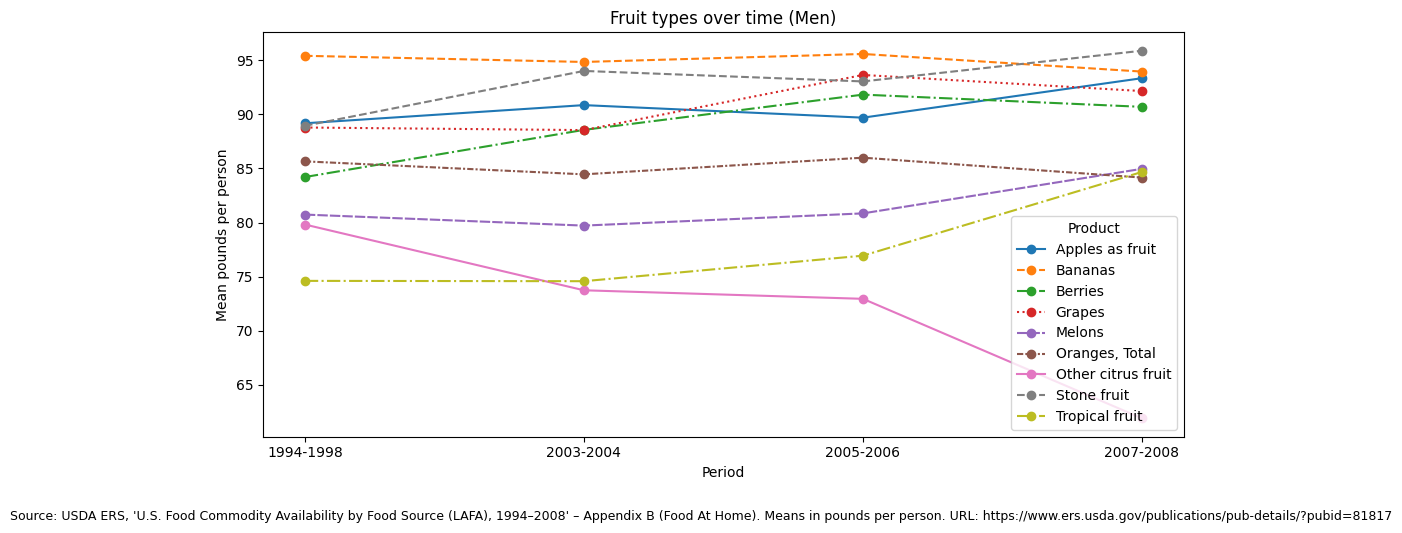

In [ ]:
plot_lines(df_men_fruit, "Fruit types over time (Men)")


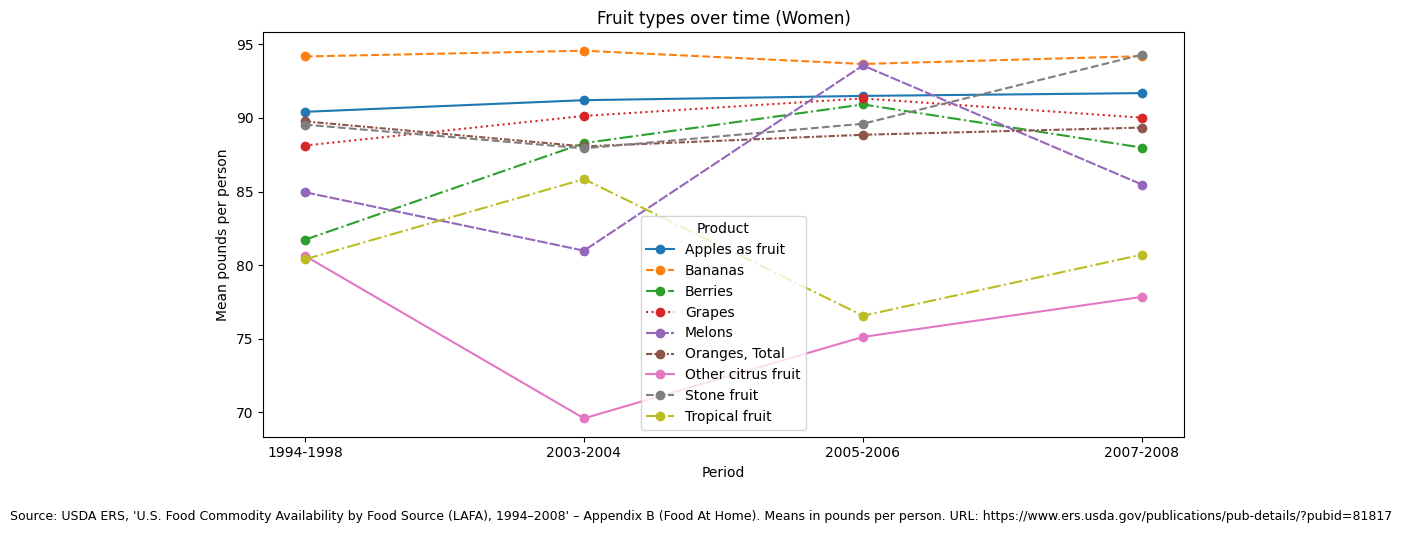

In [ ]:
plot_lines(df_women_fruit, "Fruit types over time (Women)")


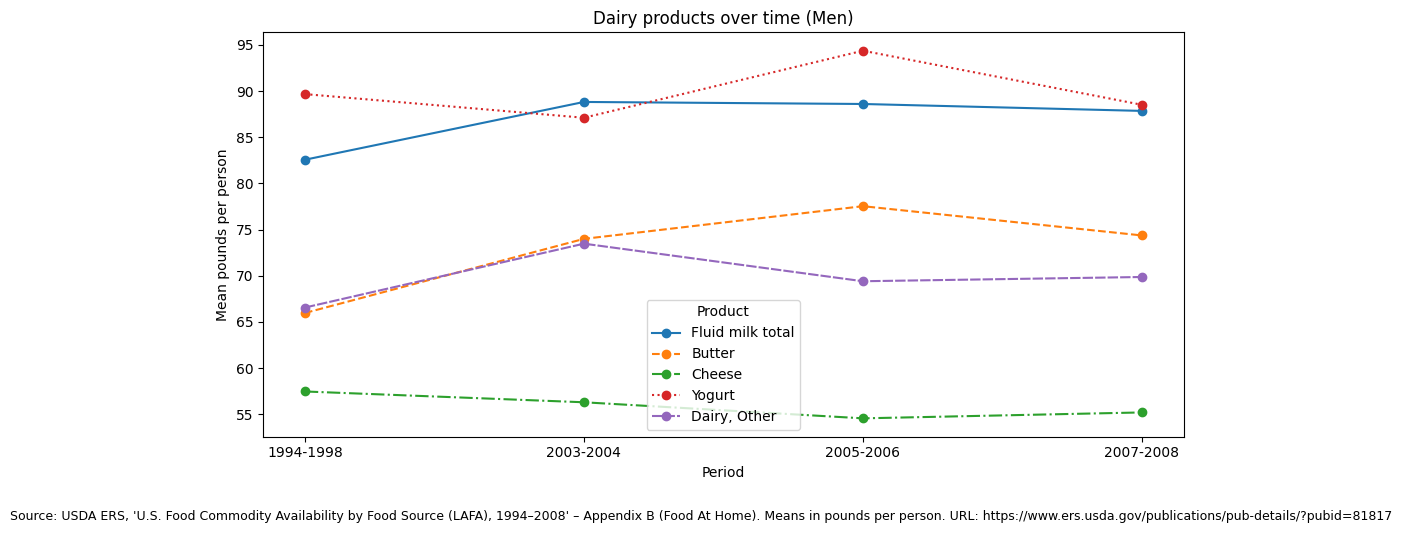

In [ ]:
plot_lines(df_men_dairy, "Dairy products over time (Men)")


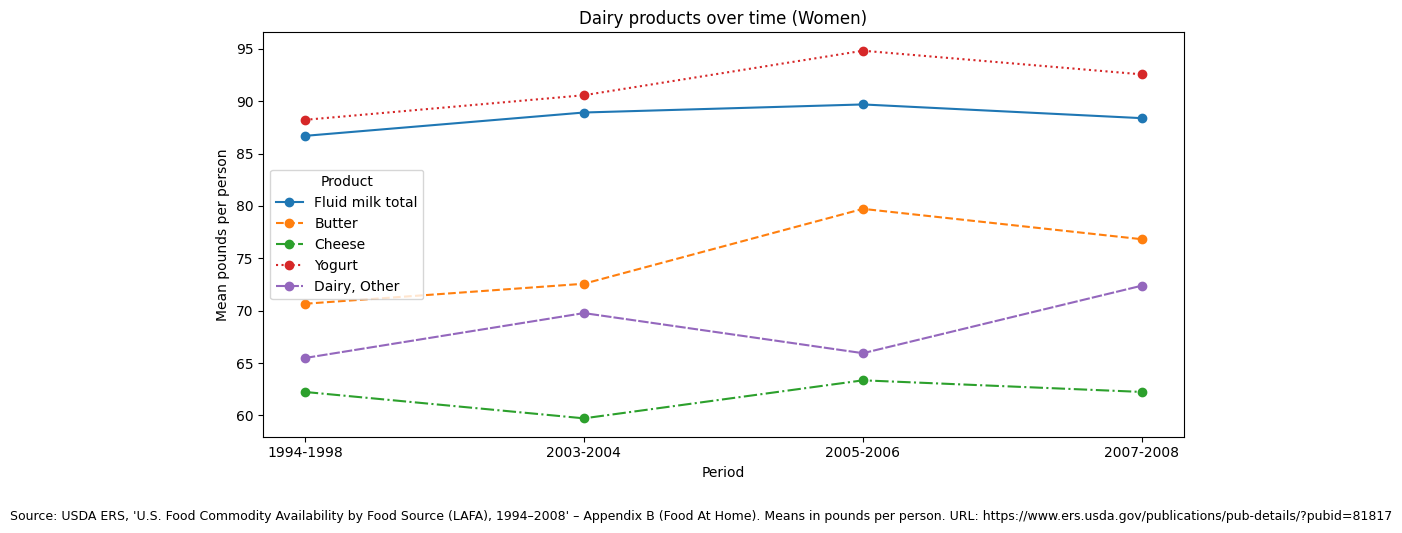

In [ ]:
plot_lines(df_women_dairy, "Dairy products over time (Women)")
